In [1]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("parn\sub-P001_ses-S001_task-Default_run-001_eeg.xdf")

Stream 3: Calculated effective sampling rate 183.1321 Hz is different from specified rate 250.0000 Hz.
Stream 4: Calculated effective sampling rate 183.1321 Hz is different from specified rate 250.0000 Hz.
Stream 1: Calculated effective sampling rate 146.5059 Hz is different from specified rate 250.0000 Hz.


In [2]:
streams[1]

{'info': defaultdict(list,
             {'name': ['obci_eeg2'],
              'type': ['EEG'],
              'channel_count': ['8'],
              'nominal_srate': ['250'],
              'channel_format': ['float32'],
              'source_id': ['openbcigui'],
              'version': ['1.1000000000000001'],
              'created_at': ['22192.307207465001'],
              'uid': ['7fd2c175-c79c-4387-bd08-97f76a85ebfd'],
              'session_id': ['default'],
              'hostname': ['MRPrayads-MacBook-Pro.local'],
              'v4address': [None],
              'v4data_port': ['16573'],
              'v4service_port': ['16573'],
              'v6address': [None],
              'v6data_port': ['0'],
              'v6service_port': ['0'],
              'desc': [None],
              'stream_id': 3,
              'effective_srate': 183.13214495884492}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['22228.403856143'],
               'last_timestamp': ['2359

In [3]:
stream_channel = 1

In [4]:
raw_data = streams[stream_channel]["time_series"].T #From Steam variable this query is EEG data
(raw_data.shape)

(8, 250050)

In [5]:
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [6]:
raw_mne_dropped = raw_mne.drop_channels(ch_names=['CH1','CH2','CH3','CH4','CH7','CH8'],on_missing='raise')

In [7]:
marker_channel = 0

In [8]:
event_index = streams[marker_channel]["time_series"].T[0] #Get all event marker of experiment 
event_timestamp = streams[marker_channel]["time_stamps"].T #Timestamp when event marked
event_index

array([ 5,  0, -1,  5,  0,  1, -1,  5,  0,  1,  2, -1,  5,  0,  1,  2,  3,
       -1,  5,  0,  1,  2,  3,  4, -1,  5,  0,  1,  2,  3,  4,  5, -1,  5,
        0,  1,  2, -1,  5,  0,  1,  2,  3, -1,  5,  0,  1,  2,  3,  4, -1,
        5,  0,  1,  2,  3,  4,  5, -1,  5,  0,  1,  2, -1,  5,  0,  1,  2,
        3, -1,  5,  0,  1,  2,  3,  4, -1,  5,  0,  1,  2,  3,  4,  5, -1,
        5,  0,  1,  2, -1,  5,  0,  1,  2,  3, -1,  5,  0,  1,  2,  3,  4,
       -1,  5,  0,  1,  2,  3,  4,  5, -1,  5,  0,  1,  2, -1,  5,  0,  1,
        2,  3, -1,  5,  0,  1,  2,  3,  4, -1,  5,  0,  1,  2,  3,  4,  5,
       -1])

In [9]:
streams[marker_channel]["time_stamps"][0]

89083.01183475002

In [10]:
event_timestamp = [0]
for i in range(1,len(streams[marker_channel]["time_series"])):
    event_timestamp.append( int(streams[marker_channel]["time_stamps"][i])-int(streams[marker_channel]["time_stamps"][0]))
event_timestamp
event_timestamp = np.array(event_timestamp)
event_timestamp = event_timestamp.T
print(type(event_timestamp))

<class 'numpy.ndarray'>


In [11]:
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))
raw_mne_dropped[0]

(array([[ 1.49012351,  3.23154569,  4.09729719, ..., -1.65835738,
         -0.41087458,  0.23150566]]),
 array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 1.000188e+03,
        1.000192e+03, 1.000196e+03]))

In [12]:
events_id = { # Set up your event name
    'reset' : -1,
   'baseline' : 0,
   'forward': 1,
   'left': 2,
   'right': 3,
   'backward': 4,
   'break': 5
}


mne_epochs = mne.Epochs(raw_mne_dropped, events, 
        tmin= 0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 15.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
     #    reject= dict(eeg = 40e-6),
     #    flat= dict(eeg = 1e-6),
        preload = True,
        baseline = (0.0,0.5),
        event_repeated='drop'
        
        
    )

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
116 matching events found


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 116 events and 3751 original time points ...
0 bad epochs dropped


In [13]:
mne_epochs

Number of events,116
Events,backward: 10baseline: 1break: 27forward: 21left: 20reset: 22right: 15
Time range,0.000 – 15.000 s
Baseline,0.000 – 0.500 s


In [14]:
dropped_log = mne_epochs.plot_drop_log

In [15]:
dropped_log

<bound method BaseEpochs.plot_drop_log of <Epochs |  116 events (all good), 0 – 15 s, baseline 0 – 0.5 s, ~6.6 MB, data loaded,
 'reset': 22
 'baseline': 1
 'forward': 21
 'left': 20
 'right': 15
 'backward': 10
 'break': 27>>

Using matplotlib as 2D backend.


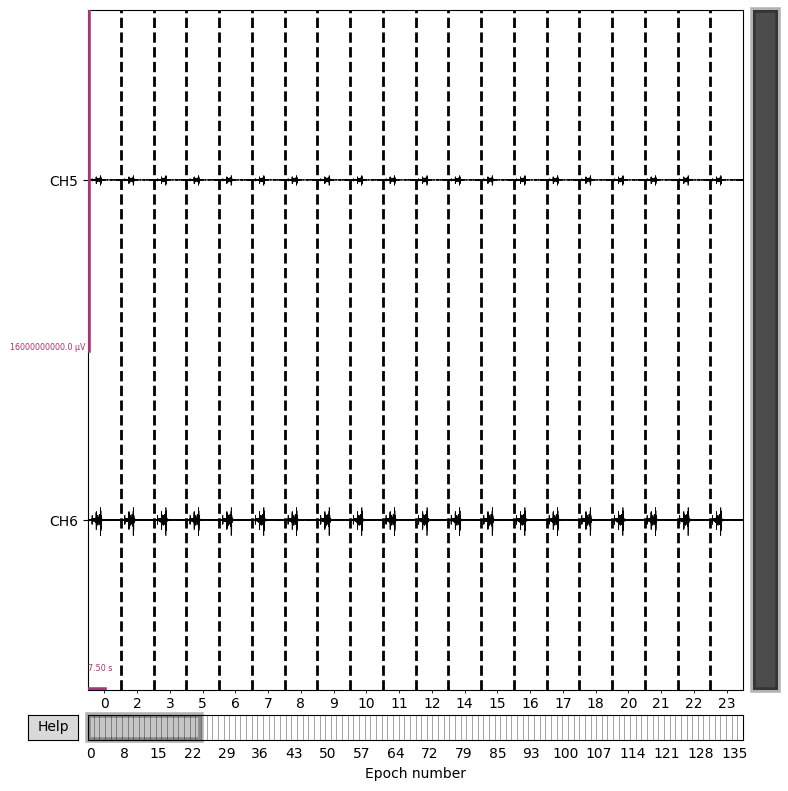

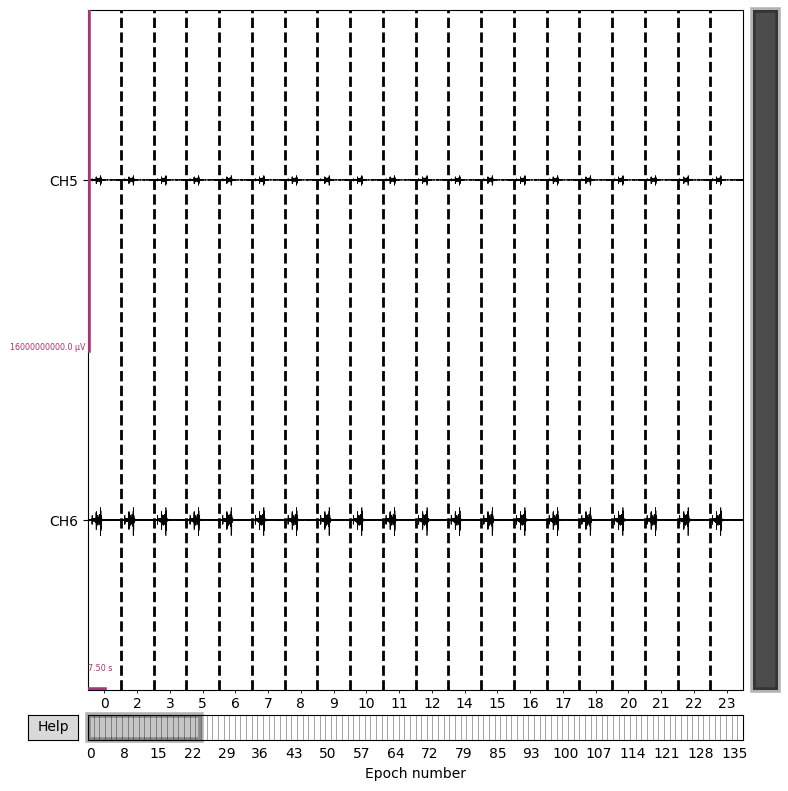

In [16]:
mne_epochs.plot(scalings = 8000)


In [17]:
print(mne_epochs.get_data().shape)
mne_epochs.get_data()

(116, 2, 3751)


C:\Users\papin\AppData\Local\Temp\ipykernel_20220\23489598.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(mne_epochs.get_data().shape)
C:\Users\papin\AppData\Local\Temp\ipykernel_20220\23489598.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  mne_epochs.get_data()


array([[[ 1.12377728e+00,  2.86519946e+00,  3.73095096e+00, ...,
         -5.40412994e-01, -1.41985150e-01,  2.08407964e+00],
        [-1.40692231e+00,  9.66685391e-02,  2.76693471e-03, ...,
          2.89817968e+00,  2.04342285e+00,  6.74941149e+00]],

       [[ 3.99973160e+00,  4.16511446e+00,  3.95172077e+00, ...,
          2.17608172e+00,  2.29796416e+00,  3.32073628e-01],
        [-4.29803531e-01,  2.42467419e+00,  4.91570035e+00, ...,
          2.04370037e+00,  1.03116385e+00, -3.84509405e+00]],

       [[ 4.80228391e+00,  2.95575180e+00,  1.61170914e+00, ...,
          4.39071098e+00,  4.90291848e+00,  6.76284566e+00],
        [ 2.79845359e+00, -1.40941534e+00, -3.68259070e+00, ...,
          6.82359102e+00,  4.17575552e+00,  7.35138156e+00]],

       ...,

       [[-2.82919397e-01, -5.15768279e-01, -4.16959976e+00, ...,
          1.98963572e+00,  2.10558713e+00,  2.10246147e+00],
        [-3.79335648e+00, -5.43201024e+00, -1.61380630e+01, ...,
         -5.35151069e-01, -4.61032

In [18]:
mne_df = mne_epochs.to_data_frame()
mne_df.head()

,time,condition,epoch,CH5,CH6
0,0.000,break,0,1.123777e+06,-1.406922e+06
1,0.004,break,0,2.865199e+06,9.666854e+04
2,0.008,break,0,3.730951e+06,2.766935e+03
3,0.012,break,0,3.823496e+06,-1.095021e+06
4,0.016,break,0,3.871064e+06,-4.732763e+05


In [19]:
mne_df['epoch'].unique()

array([  0,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
        16,  17,  18,  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,
        31,  32,  33,  35,  36,  37,  38,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,  59,  61,
        62,  63,  64,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,
        77,  79,  80,  81,  82,  83,  84,  85,  87,  88,  89,  90,  92,
        93,  94,  95,  96,  98,  99, 100, 101, 102, 103, 105, 106, 107,
       108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122,
       124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136],
      dtype=int64)

In [20]:
shift = [6,7,8,5]
n = 9
i = 0
L = [n]

In [21]:

while (n <= 136):
    n += shift[i]
    L.append(n)
    i = (i+1)%4
L = L[:-1]

In [22]:
L

[9,
 15,
 22,
 30,
 35,
 41,
 48,
 56,
 61,
 67,
 74,
 82,
 87,
 93,
 100,
 108,
 113,
 119,
 126,
 134]

In [23]:
for i in mne_df['epoch'].unique():

    print(i,mne_df[mne_df['epoch'] == i]['condition'].mode()[0])


0 break
2 reset
3 break
5 forward
6 reset
7 break
8 baseline
9 forward
10 left
11 reset
12 break
14 forward
15 left
16 right
17 reset
18 break
20 forward
21 left
22 right
23 backward
24 reset
25 break
27 forward
28 left
29 right
30 backward
31 break
32 reset
33 break
35 forward
36 left
37 reset
38 break
40 forward
41 left
42 right
43 reset
44 break
46 forward
47 left
48 right
49 backward
50 reset
51 break
53 forward
54 left
55 right
56 backward
57 break
58 reset
59 break
61 forward
62 left
63 reset
64 break
66 forward
67 left
68 right
69 reset
70 break
72 forward
73 left
74 right
75 backward
76 reset
77 break
79 forward
80 left
81 right
82 backward
83 break
84 reset
85 break
87 forward
88 left
89 reset
90 break
92 forward
93 left
94 right
95 reset
96 break
98 forward
99 left
100 right
101 backward
102 reset
103 break
105 forward
106 left
107 right
108 backward
109 break
110 reset
111 break
113 forward
114 left
115 reset
116 break
118 forward
119 left
120 right
121 reset
122 break
124 f

In [24]:
for i in L:

    print(i,mne_df[mne_df['epoch'] == i]['condition'].mode()[0])


9 forward
15 left
22 right
30 backward
35 forward
41 left
48 right
56 backward
61 forward
67 left
74 right
82 backward
87 forward
93 left
100 right
108 backward
113 forward
119 left
126 right
134 backward


In [25]:
Idle_epoch = np.array(L)-1

In [26]:
epoch = np.sort(np.concatenate((Idle_epoch,np.array(L))))

In [27]:
Idle_epoch

array([  8,  14,  21,  29,  34,  40,  47,  55,  60,  66,  73,  81,  86,
        92,  99, 107, 112, 118, 125, 133])

In [28]:
Idle_epoch = np.append(Idle_epoch[::5], Idle_epoch[-1])

In [29]:
mne_df = mne_df[mne_df['epoch'].isin(epoch)]

In [30]:
mne_df.loc[mne_df['epoch'].isin(Idle_epoch), 'condition'] = 'idle'

In [31]:
mne_df

,time,condition,epoch,CH5,CH6
22506,0.000,idle,8,4.016321e+06,2.042815e+06
22507,0.004,idle,8,2.922171e+06,1.011470e+06
22508,0.008,idle,8,1.842808e+06,1.242285e+06
22509,0.012,idle,8,7.627314e+05,1.534646e+06
22510,0.016,idle,8,-6.483378e+05,-2.741763e+05
...,...,...,...,...,...
427609,14.984,backward,134,8.822466e+04,-5.120157e+06
427610,14.988,backward,134,1.385469e+06,-2.092100e+06
427611,14.992,backward,134,1.989636e+06,-5.351511e+05
427612,14.996,backward,134,2.105587e+06,-4.610325e+05


In [32]:
mne_df['condition'].value_counts()

condition
forward     33759
left        33759
right       30008
idle        18755
backward    18755
Name: count, dtype: int64

In [33]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger


import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

import os

In [34]:
# j+=1
# name = f'model{j}'

# os.makedirs('models/'+ name)
# with open('models/'+ name +'/training_log.csv', 'w') as file:
#     pass

In [35]:
from sklearn.preprocessing import StandardScaler
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the data
channels = ['CH5', 'CH6']
mne_df[channels] = scaler.fit_transform(mne_df[channels])

In [36]:
# name

In [37]:
from INTERNET import INTERNET

interNET = INTERNET('model42')

model42
Scaler loaded successfully.
Model loaded successfully.


In [38]:
X = mne_df[['CH5','CH6']].values

In [40]:
step = 501

In [41]:
X[step:step+250].shape

(250, 2)

In [62]:
for step in range(1000):
    print(interNET.predict(X[step:step+250]))

(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 26ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 15ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 58ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 53ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 33ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116476e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 42ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819287e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 23ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 34ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 32ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 29ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 71ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 26ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 15ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 58ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193111e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311656e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106875e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106875e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116832e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969927e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106882e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 60ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819282e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 23ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311656e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8193006e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116476e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 21ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8193053e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 27ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 82ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192773e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 23ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116476e-05 9.9724448e-01 1.6969943e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116745e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819301e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819296e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 22ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116745e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106860e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 23ms/step
[[9.3116476e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 71ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 24ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.311665e-05 9.972445e-01 1.696996e-04 1.510686e-03 9.819291e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116476e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116476e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192727e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116563e-05 9.9724448e-01 1.6969927e-04 1.5106839e-03 9.8192773e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 20ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 22ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192820e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116563e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 21ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192866e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8192960e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106860e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116563e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 15ms/step
[[9.3116651e-05 9.9724448e-01 1.6969960e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 20ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 16ms/step
[[9.3116832e-05 9.9724448e-01 1.6969976e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - ETA: 0s

C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

1/1 [==============================] - 0s 18ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106846e-03 9.8192866e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 19ms/step
[[9.3116745e-05 9.9724448e-01 1.6969960e-04 1.5106868e-03 9.8193006e-04]]
[1]
(1, 250, 2)
1/1 [==============================] - 0s 17ms/step
[[9.3116651e-05 9.9724448e-01 1.6969943e-04 1.5106853e-03 9.8192913e-04]]
[1]


C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\papin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [635]:
import joblib

# Save the fitted scaler
joblib.dump(scaler, 'models/'+ name +'/standard_scaler.pkl')

['models/model42/standard_scaler.pkl']

In [698]:
scaler = joblib.load('models/'+ name +'/standard_scaler.pkl')

In [64]:
mne_df = mne_df[mne_df.condition != 'reset']
mne_df = mne_df[mne_df.condition != 'break']
mne_df  = mne_df.replace('baseline', 'Idle')
mne_df  = mne_df.replace('break', 'Idle')

In [65]:
batch_size = 64
test_size = 0.2
epochs = 128
input_size = 250

learning_rate = 0.001 
conv1d_strides = 3 #3
conv1d_filters = 36 #36
hidden_units = 32

In [638]:
from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, Reshape
from keras.layers import Conv1D, LSTM, Dropout
from keras.regularizers import l2

clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, 12, strides=conv1d_strides, activation='relu', padding='same', input_shape=(input_size, 2)))
model.add(Conv1D(conv1d_filters, 12, strides=conv1d_strides, activation='relu', padding='same'))
model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.0, kernel_regularizer=l2(0.001)))
model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.001)))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 84, 36)            900       
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 36)            15588     
                                                                 
 lstm (LSTM)                 (None, 32)                8832      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 25,485
Trainable params: 25,485
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
# Prepare the input and output
X = mne_df[['CH5', 'CH6']].values
y = mne_df['condition'].values

In [640]:
from scipy.signal import welch
def compute_psd(chunk):
    psd_features = []
    for i in range(chunk.shape[1]):  # Iterate over each feature (column)
        f, Pxx = welch(chunk[:, i], fs=250, nperseg=chunk.shape[0])
        psd_features.append(Pxx)
    return np.array(psd_features).flatten()  # Flatten the PSD features

In [70]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encoding for the condition column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_categorical = to_categorical(y_encoded, num_classes=5)

y_ordered = y_categorical[input_size-1:] 

indices = np.arange(input_size) + np.arange(len(X) - input_size + 1)[:, np.newaxis]
X_ordered = X[indices]

# X_with_psd = np.array([np.concatenate((chunk.flatten(), compute_psd(chunk))) for chunk in X_ordered])

shuffled_indices = np.random.permutation(len(X_ordered)) 
X_random = X_ordered[shuffled_indices]
y_random = y_ordered[shuffled_indices]

In [642]:
checkpoint = ModelCheckpoint(
                            filepath='models/'+name+'/checkpoint-epoch{epoch:02d}-loss{val_loss:.4f}.h5',
                            monitor='val_loss',
                            verbose=16,
                            save_best_only=False,
                            save_weights_only=False,
                            mode='auto',
                            save_freq='epoch',
                            period=16
                            )

csv_logger = CSVLogger('models/'+name+'/training_log.csv', append=True)

In [643]:
from keras.callbacks import ReduceLROnPlateau, Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [644]:
# Custom callback to print the learning rate
class PrintLearningRate(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.eval(self.model.optimizer.lr)
        print(f'\nLearning rate after epoch {epoch+1}: {lr}')

# Instantiate the custom callback
print_lr = PrintLearningRate()

In [645]:
# Train Model ###################################################
model.fit(X_random,y_random, epochs=epochs, batch_size=batch_size, validation_split=test_size, callbacks=[checkpoint, csv_logger, reduce_lr,print_lr ])    

Epoch 1/128
1684/1685 [============================>.] - ETA: 0s - loss: 1.0784 - accuracy: 0.5360
Learning rate after epoch 1: 0.0010000000474974513
1685/1685 [==============================] - 18s 10ms/step - loss: 1.0782 - accuracy: 0.5361 - val_loss: 0.7603 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 2/128
1685/1685 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7691
Learning rate after epoch 2: 0.0010000000474974513
1685/1685 [==============================] - 16s 9ms/step - loss: 0.5978 - accuracy: 0.7691 - val_loss: 0.4454 - val_accuracy: 0.8395 - lr: 0.0010
Epoch 3/128
1683/1685 [============================>.] - ETA: 0s - loss: 0.4658 - accuracy: 0.8312
Learning rate after epoch 3: 0.0010000000474974513
1685/1685 [==============================] - 16s 9ms/step - loss: 0.4658 - accuracy: 0.8312 - val_loss: 0.4989 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 4/128
1680/1685 [============================>.] - ETA: 0s - loss: 0.4031 - accuracy: 0.8577
Learning 

In [661]:
model.save('models/'+name+'/'+name+'.h5')

In [67]:
from keras.models import load_model
model = load_model('models\model36_95_7ms\model36.h5')

In [71]:
y_test = y_encoded[input_size-1:] 
indices = np.arange(input_size) + np.arange(len(X)-input_size+1)[:,np.newaxis] 
X_test = tf.gather(X,indices) 

prediction = model.predict(X_test, batch_size=batch_size)

2107/2107 [==============================] - 4s 2ms/step


In [78]:
X_test[0]

<tf.Tensor: shape=(250, 2), dtype=float64, numpy=
array([[ 1.57587060e-01,  2.95301346e-02],
       [ 1.13839403e-01,  1.47428794e-02],
       [ 7.06829573e-02,  1.80522651e-02],
       [ 2.74979733e-02,  2.22441005e-02],
       [-2.89211604e-02, -3.69050103e-03],
       [-6.47227176e-02, -1.86653498e-02],
       [-7.75191949e-02,  9.28975719e-03],
       [-1.15929837e-01, -7.56031910e-03],
       [-1.45256465e-01, -1.95504658e-02],
       [-1.66538643e-01, -2.94824046e-02],
       [-1.93796740e-01, -5.53611664e-02],
       [-2.16144137e-01, -8.60752812e-02],
       [-2.07070789e-01, -9.00796229e-02],
       [-1.75430468e-01, -7.25105387e-02],
       [-1.61935926e-01, -7.34859878e-02],
       [-1.75766898e-01, -9.98203583e-02],
       [-1.80395543e-01, -1.10423865e-01],
       [-1.55394134e-01, -8.45550065e-02],
       [-1.22952776e-01, -4.91086858e-02],
       [-1.00485333e-01, -2.43383149e-02],
       [-7.09887799e-02,  6.57766449e-03],
       [-5.49885361e-02,  1.67420822e-02],
    

In [82]:
X_test.shape

TensorShape([134787, 250, 2])

In [80]:
X_test[2]

<tf.Tensor: shape=(250, 2), dtype=float64, numpy=
array([[ 7.06829573e-02,  1.80522651e-02],
       [ 2.74979733e-02,  2.22441005e-02],
       [-2.89211604e-02, -3.69050103e-03],
       [-6.47227176e-02, -1.86653498e-02],
       [-7.75191949e-02,  9.28975719e-03],
       [-1.15929837e-01, -7.56031910e-03],
       [-1.45256465e-01, -1.95504658e-02],
       [-1.66538643e-01, -2.94824046e-02],
       [-1.93796740e-01, -5.53611664e-02],
       [-2.16144137e-01, -8.60752812e-02],
       [-2.07070789e-01, -9.00796229e-02],
       [-1.75430468e-01, -7.25105387e-02],
       [-1.61935926e-01, -7.34859878e-02],
       [-1.75766898e-01, -9.98203583e-02],
       [-1.80395543e-01, -1.10423865e-01],
       [-1.55394134e-01, -8.45550065e-02],
       [-1.22952776e-01, -4.91086858e-02],
       [-1.00485333e-01, -2.43383149e-02],
       [-7.09887799e-02,  6.57766449e-03],
       [-5.49885361e-02,  1.67420822e-02],
       [-5.27004045e-02,  1.02383167e-02],
       [-3.26569497e-02,  2.28103356e-02],
    

In [682]:
one_hot_output = np.zeros_like(prediction)
one_hot_output[np.arange(len(prediction)), prediction.argmax(1)] = 1

print(one_hot_output)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [683]:
label_encoder.inverse_transform([0,1])

array(['backward', 'forward'], dtype=object)

In [684]:
reversed_array = np.argmax(one_hot_output, axis=1)

In [686]:
y_pred = label_encoder.inverse_transform(reversed_array)

In [687]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have your actual labels and predicted labels
actual_labels = y[len(y) - len(y_pred):]
predicted_labels = label_encoder.inverse_transform(reversed_array)

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

# Calculate precision
precision = precision_score(actual_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(actual_labels, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(actual_labels, predicted_labels, average='macro')

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9532076535570938
Precision: 0.9488059974244643
Recall: 0.9589289555847458
F1-score: 0.9531823594621477
Confusion Matrix:
[[18706     1    24     0    24]
 [  155 31948   222  1332   102]
 [    1    20 17977   499     9]
 [   87   615  1984 31044    29]
 [  639    19   241   304 28805]]


In [688]:
conf_matrix

array([[18706,     1,    24,     0,    24],
       [  155, 31948,   222,  1332,   102],
       [    1,    20, 17977,   499,     9],
       [   87,   615,  1984, 31044,    29],
       [  639,    19,   241,   304, 28805]], dtype=int64)

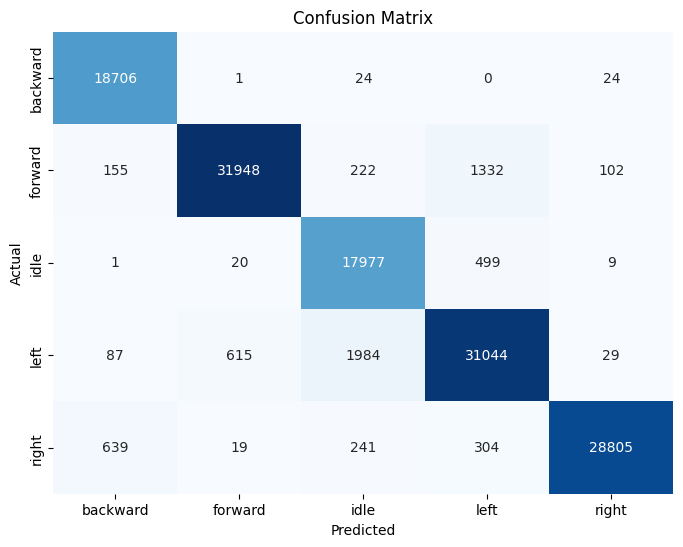

In [689]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


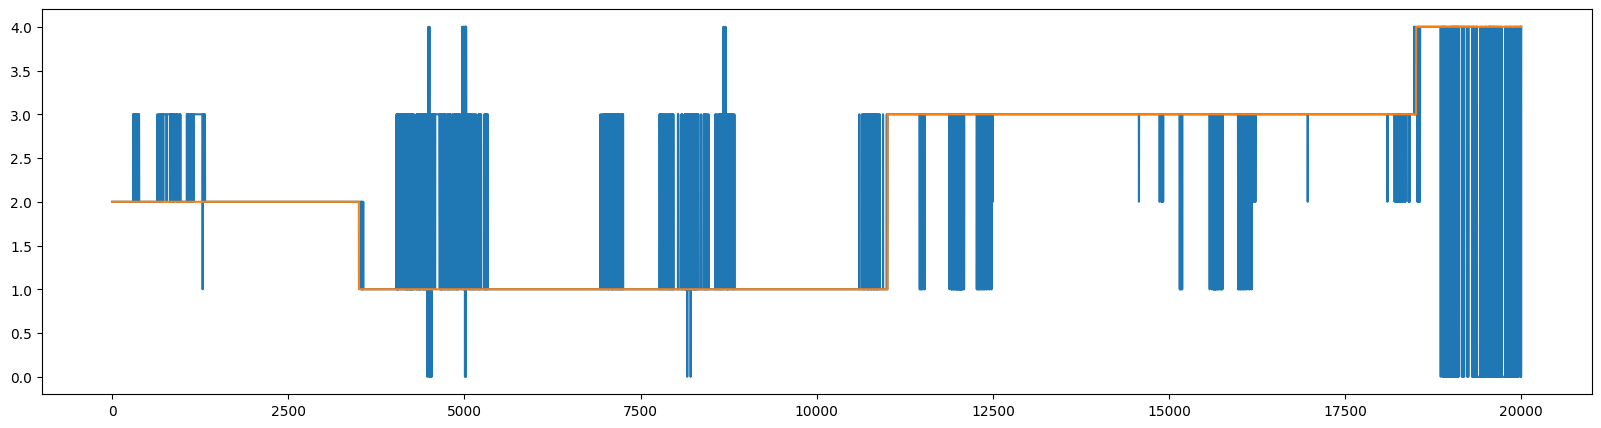

In [693]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(reversed_array[:20000])
plt.plot(y_encoded[len(y) - len(y_pred):20000 + len(y) - len(y_pred)])
plt.show()

In [691]:
predicted_labels

array(['idle', 'idle', 'idle', ..., 'backward', 'backward', 'backward'],
      dtype=object)

In [692]:
unique, counts = np.unique(y_encoded, return_counts=True)
print(dict(zip(unique, counts)))


{0: 18755, 1: 33759, 2: 18755, 3: 33759, 4: 30008}
